# Corporación Favorita Grocery Sales Forecasting Project


# Part 1- Installation and Liberaries importation

✅ Step 0: Install Required Packages

In [3]:
#!pip install -U gdown
#!pip install statsmodels

✅ Step 1: Import Libraries

In [5]:
#  Ignore warning suggetions given by Python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import requests
import gdown
import io
from matplotlib import pyplot as plt
import seaborn as sns
#from google.colab import drive
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
# Build the download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

✅ Step 2: Dictionary of file IDs for clarity

In [7]:
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

✅ Step 3: Load each CSV using the helper functions

In [8]:
# Load all files using the helper functions except train.csv

df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))
# df_train          = load_csv_from_url(make_drive_url(file_ids["train"]))

# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file


In [9]:
# Quick Test to Confirm
display(df_stores.head())
display(df_items.head())
display(df_holiday_events.head())
display(df_oil.head())
display(df_transactions.head())


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


What each dataframe represents:
- df_train – daily sales by store and product
- df_items – details about each item
- df_stores – store locations and types
- df_oil – oil prices (a possible external influence on sales)
- df_transactions – total store traffic per day
- df_holiday_events – national/local holidays and special events

In [10]:
# Download the train.csv file using gdown
train_url = make_drive_url(file_ids["train"])
gdown.download(train_url, "train.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=ad27aba6-e5f7-493f-8065-4e404e8056a0
To: C:\Users\onyiu\Documents\python_code\favorita_project\train.csv
100%|█████████████████████████████████████████████████████████████████████████████| 5.00G/5.00G [12:56<00:00, 6.43MB/s]


'train.csv'

# Part 2: Exploratory Data Analysis (EDA)

 We need to filter out the data to get **only Guayas region**.

we can experiment with different chunksize values.
A chunksize of 100,000 to 1,000,000 rows is a good starting point.


In [66]:
# Select list of stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6              # Read 1 million rows at a time & Adjust based on system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('./train.csv', chunksize=chunk_size):
  chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]  # Filter the chunk for the desired store IDs
  filtered_chunks.append(chunk_filtered)                    # Append the filtered chunk to the list

  del chunk                                                 # Delete the chunk to free up memory

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)      # ignore index set to TRUE, so that we don't have any problems during concatenation.



del filtered_chunks             # Delect and Clean up to free memory

In [67]:
df_train.shape

(22941656, 6)

The dataset that we have is still very big even after filtering. To prevent our work from unexpected crashes, let's limit the dataset to include only top-3 families by number of items but first let's look at this top-3:

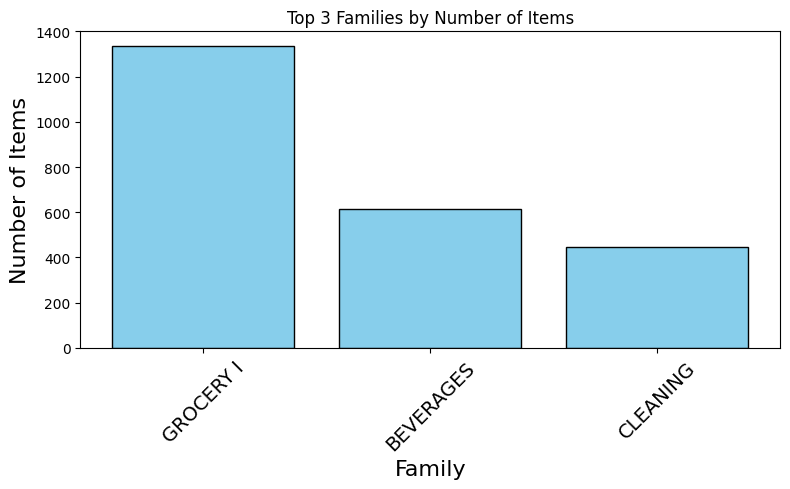

'\nwe have groceries, beverages and cleaning.\nSo these are top 3 families of items that customers normally purchase.\nthis is a part of EDA exploratory data analysis.\n'

In [68]:
# # Compute the number of items per family and select the top 3 families
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family','Item Count'] # rename items_per_family
top_3_families = items_per_family.head(3) # [:3]  #  no need to do any sorting, because Value counts already returns it in descending order.

# plot the top 3 family
plt.figure(figsize = (8,5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'],
        color = 'skyblue', edgecolor = 'black')
plt.title('Top 3 Families by Number of Items')
plt.xlabel("Family", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.tight_layout()
plt.show()

"""
we have groceries, beverages and cleaning.
So these are top 3 families of items that customers normally purchase.
this is a part of EDA exploratory data analysis.
"""

we want to filter a little further.

In [70]:
#  filtering items that only belong to groceries, beverages, and cleaning.
# And use this list of items to filter training dataset.

item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]          # Df train will be the DF train where df_train item number is in item_ids.
